This notebook is primary geared towards looking at the algorithm output.

In particular, since the compute job was stopped due to Cheyenne maintenance, I save intermediate $w$, $c$, and $\lambda$ vectors to `./data/results/00/...`.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
from scipy import stats
from scipy.optimize import minimize

In [2]:
from generate_opt_objects import A_b_generation

In [3]:
from admm_optimizer import c_update_obj, c_update_obj_grad, endpoint_objective

In [4]:
# results base directory
BASE_DIR = './data/carbon_flux/results'

# Intermediate output

In [5]:
with open(BASE_DIR + '/00/opt_output_00.pkl', 'rb') as f:
    int_out_00 = pickle.load(f)
print(int_out_00)

{'objective_evals': [-27440.898721911864], 'w_opt_vecs': array([[-0.20471723,  0.47914934, -0.51938276, ...,  0.96201749,
         1.57496643,  0.72282295],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]]), 'c_opt_vecs': array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]]), 'lambda_opt_vecs': array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 

In [6]:
np.where(int_out_00['c_opt_vecs'] != 0)

(array([0, 0, 0, ..., 0, 0, 0]),
 array([   18,    19,    31, ..., 11060, 11061, 11062]))

# Other necessary output

1. $y$ -- affine corrected and normalized
2. $\psi_\alpha$
3. gosat observations for cholesky factor

In [7]:
# read in gosat observation and make the cholesky factor vector
gosat_df = pd.read_csv('./data/carbon_flux/objects/gosat_df_jan1_aug31_2010.csv')
L_inv_vec = 1 / gosat_df.xco2_unc.values

In [8]:
# affine corrected and normalized observation
with open('./data/carbon_flux/objects/y_affine_corrected.npy', 'rb') as f:
    y_obs = np.load(f)
y_tilde = np.multiply(L_inv_vec, y_obs)

In [9]:
# psi alpha value
with open('./data/carbon_flux/objects/opt_res_cont.pkl', 'rb') as f:
    opt_slack = pickle.load(f)
PSI2 = stats.chi2.ppf(q=.95, df=1) + opt_slack[1]
psi_alpha = np.sqrt(PSI2)

# Feasibility conditions

\begin{equation}
\lVert h + A^T c - K^T w \rVert_2^2
\end{equation}

In [10]:
# import results dictionary
with open(BASE_DIR + '/00/opt_output_00.pkl', 'rb') as f:
    res_dict = pickle.load(f)
    
print(list(res_dict.keys()))

['objective_evals', 'w_opt_vecs', 'c_opt_vecs', 'lambda_opt_vecs', 'KTw_vecs']


In [11]:
# import h
with open('./data/carbon_flux/objects/na_june_functional.npy', 'rb') as f:
    h = np.load(f)

# import A
A, b = A_b_generation(
    box_constraint_fp='./data/carbon_flux/objects/scipy_bnds.pkl'
)

print(f'Dim of A: {A.shape}')
print(f'Dim of b: {b.shape}')

Dim of A: (11120, 26496)
Dim of b: (11120,)


In [12]:
# extract plotting objects from results_dict
KTw_vecs = res_dict['KTw_vecs'].copy()
c_vecs = res_dict['c_opt_vecs'].copy()

# look at the norm of the constraint term
num_iters = KTw_vecs.shape[0]
print(f'Number of iterations: {num_iters}')

constr_mat = np.array([
    h + A.T @ c_vecs[i, :] - KTw_vecs[i, :]
    for i in range(num_iters)
])
feasibility = np.sqrt(np.diagonal(constr_mat @ constr_mat.T))

Number of iterations: 10


In [13]:
feasibility

array([25.97606915,  0.17412791,  0.17412791,  0.17412791,  0.17412791,
        0.17412791,  0.17412791,  0.17412791,  0.17412791,  0.17412791])

# $w$ optimization

By reconstructing output, we can:
1. compute feasibility conditions
2. look at the actual interval endpoint values

### Obtaining $K^Tw$ vectors

In [14]:
with open(BASE_DIR + '/00/h_table_lep.pkl', 'rb') as f:
    KTw_dict_01 = pickle.load(f)

In [15]:
# pull out all the w and K^Tw vectors
hash_keys = list(KTw_dict_01.keys())[1:]
NUM_VECS = len(list(KTw_dict_01.keys())) - 1
DIM_W = KTw_dict_01[hash_keys[0]]['w'].shape[0]
DIM_KTW = KTw_dict_01[hash_keys[0]]['KTw'].shape[0]
w_01 = np.zeros(shape=(NUM_VECS, DIM_W))
KTw_01 = np.zeros(shape=(NUM_VECS, DIM_KTW))

for i, key_i in enumerate(hash_keys):
    w_01[i, :] = KTw_dict_01[key_i]['w']
    KTw_01[i, :] = KTw_dict_01[key_i]['KTw']

In [16]:
# read in callback
with open(BASE_DIR + '/00/callback_w_opt_01.txt', 'r') as f:
    w_opt_1_long = np.loadtxt(f)
w_callback_vecs = np.reshape(w_opt_1_long, newshape=(10, DIM_W), order='C')
print(w_opt_1_long.shape)
print(w_callback_vecs.shape)

(282670,)
(10, 28267)


In [17]:
# save the indices corresponding the KTw
KTw_idxs = np.zeros(10)
for i in range(10):
    KTw_idxs[i] = np.linalg.norm(w_callback_vecs[i, :] - w_01, axis=1).argmin()

In [18]:
# isolate the actual KTw evaluations corresponding to each w
KTw_evals = np.zeros(shape=(10, DIM_KTW))
for i in range(10):
    KTw_evals[i, :] = KTw_01[int(KTw_idxs[i]), :]

### Looking at the optimizer updates for the second ADMM iteration

In [19]:
# read in the raw stdout file
with open(BASE_DIR + '/00/stdout.txt', 'r') as f:
    stdout_raw = f.readlines()

In [20]:
# isolate the trajectories from the first and second w optimizations
traj_w_1 = [float(line[23:34].replace('D', 'e')) for line in stdout_raw if 'At iterate' in line][:12]
traj_w_2 = [float(line[23:34].replace('D', 'e')) for line in stdout_raw if 'At iterate' in line][-10:]
print(len(traj_w_1))
print(len(traj_w_2))

12
10


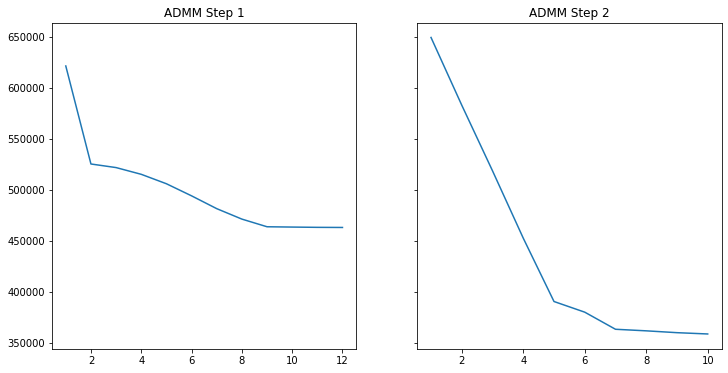

In [21]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(12, 6), sharey=True)
ax[0].plot(np.arange(1, 13), traj_w_1)
ax[1].plot(np.arange(1, 11), traj_w_2)

ax[0].set_title('ADMM Step 1')
ax[1].set_title('ADMM Step 2')

plt.show()

#### Save the last $w$ vectors

In [26]:
# save the last w vector
with open(BASE_DIR + '/00/cheyenne_stop_w_vec.npy', 'wb') as f:
    np.save(file=f, arr=w_callback_vecs[-1, :])

### Perform the $c$ and $\lambda$ updates

In [27]:
# c-update
c0 = c_vecs[0, :].copy()
KTw_it2 = KTw_evals[-1, :]  # i.e., the adjoint evaluated at the ending w
lambda_it1 = res_dict['lambda_opt_vecs'][0, :]
d = c0.shape[0]

c_opt_res = minimize(
    fun=c_update_obj,
    x0=c_vecs[0, :],
    jac=c_update_obj_grad,
    args=(
        KTw_it2, lambda_it1, 1e3, True, A, b, h
    ),
    bounds=[(0, np.inf)] * d,
    method='L-BFGS-B',
    options={
        'maxls': 50,
        'disp': True
    }
)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        11120     M =           10

At X0      8342 variables are exactly at the bounds

At iterate    0    f= -2.05631D+05    |proj g|=  1.58207D+03

At iterate    1    f= -2.65567D+05    |proj g|=  1.03604D+03

At iterate    2    f= -3.11799D+05    |proj g|=  2.50111D-12

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
11120      2      4    146     0  7181   2.501D-12  -3.118D+05
  F =  -311798.75779027055     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


In [30]:
# save the c vector from above
with open(BASE_DIR + '/00/cheyenne_stop_c_vec.npy', 'wb') as f:
    np.save(file=f, arr=c_opt_res['x'])

In [31]:
# update lambda
lambda_it2 = lambda_it1 + 1e3 * (h + A.T @ c_opt_res['x'] - KTw_it2)

In [36]:
# save the lambda vector from above
with open(BASE_DIR + '/00/cheyenne_stop_lambda_vec.npy', 'wb') as f:
    np.save(file=f, arr=lambda_it2)

In [32]:
# compute the new endpoint
endpoint_objective(
    w=w_callback_vecs[-1, :],
    c=c_opt_res['x'],
    b=b,
    y=y_tilde,
    lep=True,
    psi_alpha=psi_alpha
)

-34288.713763677515

In [33]:
# feasibility condition
np.linalg.norm(h + A.T @ c_opt_res['x'] - KTw_it2)

13.014071244823715